<a href="https://colab.research.google.com/github/QuangHPV/sc1015-project/blob/main/XGBoost_Weather_AUS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# XGBoost for Weather_AUS dataset

In this notebook, I will use XGBoost for processing the Weather_AUS dataset. I will use the model to classify whether tomorrow will rain or not. XGBoost is a tree based algorithm, which works quite well for table data. We will use both cleaning method of `KNN Imputaion` and `outliers removing` to see which one is better

## Load the dataset

In [1]:
!git clone https://github.com/QuangHPV/sc1015-project.git

Cloning into 'sc1015-project'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 71 (delta 23), reused 34 (delta 6), pack-reused 0
Receiving objects: 100% (71/71), 16.69 MiB | 12.24 MiB/s, done.
Resolving deltas: 100% (23/23), done.


## Import libraries

In [2]:
!pip install xgboost

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
# Import specific model
import xgboost as xgb
from xgboost import XGBClassifier

# Preprocess

In [4]:
df = pd.read_csv('/content/sc1015-project/data/weatherAUS_cleaned_final.csv')
df.head()

,Unnamed: 0,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,0,2008-12-01,2,13.4,22.9,0.6,4.8,8.4,13,44.0,...,71.0,22.0,1007.7,1007.1,8.0,7.0,16.9,21.8,0,0
1,1,2008-12-02,2,7.4,25.1,0.0,4.8,8.4,14,44.0,...,44.0,25.0,1010.6,1007.8,2.0,7.0,17.2,24.3,0,0
2,2,2008-12-03,2,12.9,25.7,0.0,4.8,8.4,15,46.0,...,38.0,30.0,1007.6,1008.7,7.0,2.0,21.0,23.2,0,0
3,3,2008-12-04,2,9.2,28.0,0.0,4.8,8.4,4,24.0,...,45.0,16.0,1017.6,1012.8,5.0,5.0,18.1,26.5,0,0
4,4,2008-12-05,2,17.5,32.3,1.0,4.8,8.4,13,41.0,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0,0


In [5]:
df.shape

(126618, 24)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126618 entries, 0 to 126617
Data columns (total 24 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Unnamed: 0     126618 non-null  int64  
 1   Date           126618 non-null  object 
 2   Location       126618 non-null  int64  
 3   MinTemp        126618 non-null  float64
 4   MaxTemp        126618 non-null  float64
 5   Rainfall       126618 non-null  float64
 6   Evaporation    126618 non-null  float64
 7   Sunshine       126618 non-null  float64
 8   WindGustDir    126618 non-null  int64  
 9   WindGustSpeed  126618 non-null  float64
 10  WindDir9am     126618 non-null  int64  
 11  WindDir3pm     126618 non-null  int64  
 12  WindSpeed9am   126618 non-null  float64
 13  WindSpeed3pm   126618 non-null  float64
 14  Humidity9am    126618 non-null  float64
 15  Humidity3pm    126618 non-null  float64
 16  Pressure9am    126618 non-null  float64
 17  Pressure3pm    126618 non-nul

In [7]:
df.describe()

,Unnamed: 0,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
count,126618.000000,126618.000000,126618.000000,126618.000000,126618.000000,126618.000000,126618.000000,126618.000000,126618.000000,126618.000000,...,126618.000000,126618.000000,126618.000000,126618.000000,126618.000000,126618.000000,126618.000000,126618.000000,126618.000000,126618.000000
mean,70659.218942,23.653225,12.082247,23.108766,2.130779,5.058593,7.612482,7.994227,37.934054,7.014666,...,69.967066,51.976220,1018.155575,1015.728022,4.402881,4.486534,16.845189,21.598057,0.213714,0.211802
std,41196.164812,14.183619,6.288160,6.648153,7.730380,2.999342,3.681647,4.700384,10.642012,4.523692,...,17.537547,19.577156,6.035665,6.012837,2.891001,2.730413,6.201127,6.399556,0.409929,0.408587
min,0.000000,0.000000,-7.600000,-3.800000,0.000000,0.000000,0.000000,0.000000,9.000000,0.000000,...,21.000000,1.000000,1002.000000,999.700000,0.000000,0.000000,-1.100000,3.100000,0.000000,0.000000
25%,34376.250000,11.000000,7.500000,18.100000,0.000000,2.700000,5.000000,4.000000,31.000000,3.000000,...,58.000000,38.000000,1014.200000,1011.700000,1.000000,2.000000,12.300000,16.900000,0.000000,0.000000
50%,71303.500000,24.000000,11.900000,22.600000,0.000000,4.800000,8.400000,9.000000,39.000000,7.000000,...,70.000000,52.000000,1017.600000,1015.200000,5.000000,5.000000,16.600000,21.100000,0.000000,0.000000
75%,106708.750000,36.000000,16.600000,27.900000,0.600000,7.000000,10.500000,12.000000,44.000000,11.000000,...,83.000000,65.000000,1022.100000,1019.700000,7.000000,7.000000,21.200000,26.000000,0.000000,0.000000
max,142192.000000,48.000000,31.400000,45.400000,371.000000,14.300000,14.500000,15.000000,67.000000,15.000000,...,100.000000,100.000000,1034.300000,1031.700000,9.000000,9.000000,34.800000,39.900000,1.000000,1.000000


We will, again, encoded the labels and remove Date, as we do not work with time series data

In [8]:
object_cols = ['Location',
                'WindGustDir',
                'WindDir9am',
                'WindDir3pm',
                'RainToday',
                'RainTomorrow',
               'Cloud9am',
               'Cloud3pm',
               'RainToday']
# Initialize the LabelEncoder


def encode_categorical_columns_label_encoding(df, columns_to_encode):
    """
    Applies Label Encoding to specified categorical columns in the DataFrame,
    retains all other columns unchanged, and prints the mapping from original
    categorical values to encoded numeric codes.

    Parameters:
    - df: pandas DataFrame containing the columns to encode.
    - columns_to_encode: list of strings, names of the categorical columns to be encoded.

    Returns:
    - A new DataFrame with specified columns label encoded and all other columns unchanged.
    """
    # Copy the DataFrame to avoid modifying the original data
    encoded_df = df.copy()

    # Initialize LabelEncoder
    encoder = LabelEncoder()

    # Loop through each column to encode
    for column in columns_to_encode:
        # Apply LabelEncoder and replace the column in the DataFrame
        encoded_df[column] = encoder.fit_transform(df[column])

        # Print the mappings for each encoded column
        mappings = {index: label for index, label in enumerate(encoder.classes_)}
        print(f"Encoding mapping for '{column}': {mappings}")

    return encoded_df

encoded_df = encode_categorical_columns_label_encoding(df, object_cols)

Encoding mapping for 'Location': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29, 30: 30, 31: 31, 32: 32, 33: 33, 34: 34, 35: 35, 36: 36, 37: 37, 38: 38, 39: 39, 40: 40, 41: 41, 42: 42, 43: 43, 44: 44, 45: 45, 46: 46, 47: 47, 48: 48}
Encoding mapping for 'WindGustDir': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15}
Encoding mapping for 'WindDir9am': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15}
Encoding mapping for 'WindDir3pm': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15}
Encoding mapping for 'RainToday': {0: 0, 1: 1}
Encoding mapping for 'RainTomorrow': {0: 0, 1: 1}
Encoding mapping for 'Cloud9am': {0: 0.0, 1: 1.0, 2: 2.0, 3: 3.0

# Problem Statement
From the numerical dataset, I will create a XGBoost Model for predicting whether today is raining or not. XGBoost is a tree-based model, and it's really good at classification and regression task, as it capacity and its mechanism behind.

For better prediction, I will use Standard Scaler to Normalize data, make the model easier to learn from our cleaned numerical dataset

# Model

## Using Manually cleaning dataset

In [9]:
X = encoded_df.drop(['Date', 'RainTomorrow'], axis=1)
y = encoded_df['RainTomorrow']
print('Len of X', len(X))
print('Len of y', len(y))

Len of X 126618
Len of y 126618


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Normalize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
# Initialize the classifier
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')


# Fit the model
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [13]:
y_pred = model.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [14]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.861870162691518

Then, I will use confusion matrix to see which part of our model is weak.

In [15]:
# utils for visualization
def visualize_preds(y_true, y_pred, title):
    ls = []
    f = plt.figure(figsize = (8,8))
    cf = confusion_matrix(y_true, y_pred)
    sns.heatmap(cf, fmt='.0f', annot=True)

    accuracy  = np.trace(cf) / float(np.sum(cf))

    # Metrics for Binary Confusion Matrices
    if sum(cf[:,1]) == 0:
        precision = 0.0;
    else:
        precision = cf[1,1] / sum(cf[:,1])

    if sum(cf[1,:]) == 0:
        recall = 0.0;
    else:
        recall    = cf[1,1] / sum(cf[1,:])

    if (precision + recall) == 0:
        f1_score = 0.0;
    else:
        f1_score  = 2 *precision * recall / (precision + recall)
    stats_text = "\n\nAccuracy={:0.2f}\nPrecision={:0.2f}\nRecall={:0.2f}\nF1 Score={:0.2f}".format(
        accuracy,precision,recall,f1_score)

    ls.append(accuracy)
    ls.append(precision)
    ls.append(recall)
    ls.append(f1_score)
    ls = pd.DataFrame(ls)


    plt.xlabel('Predicted' + stats_text)
    plt.ylabel('Actual')
    plt.title(title)


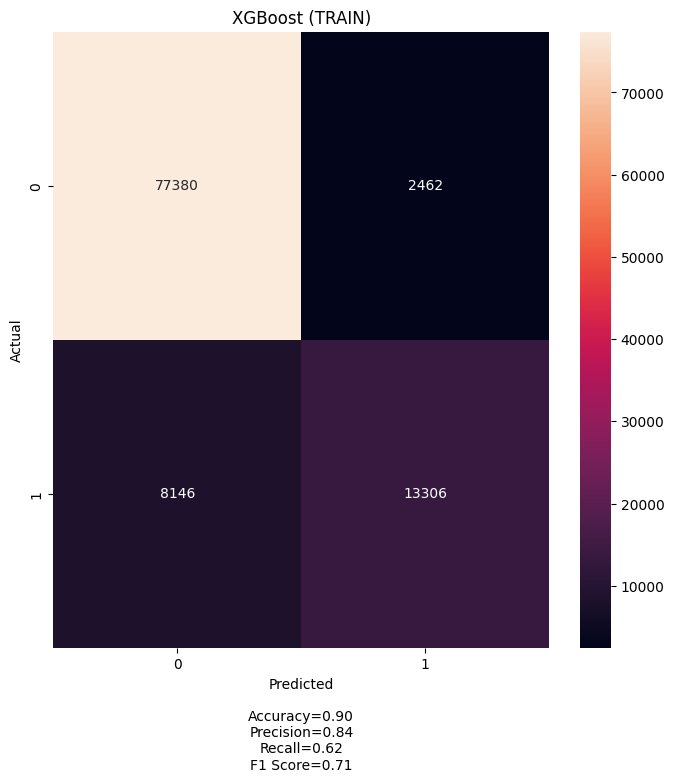

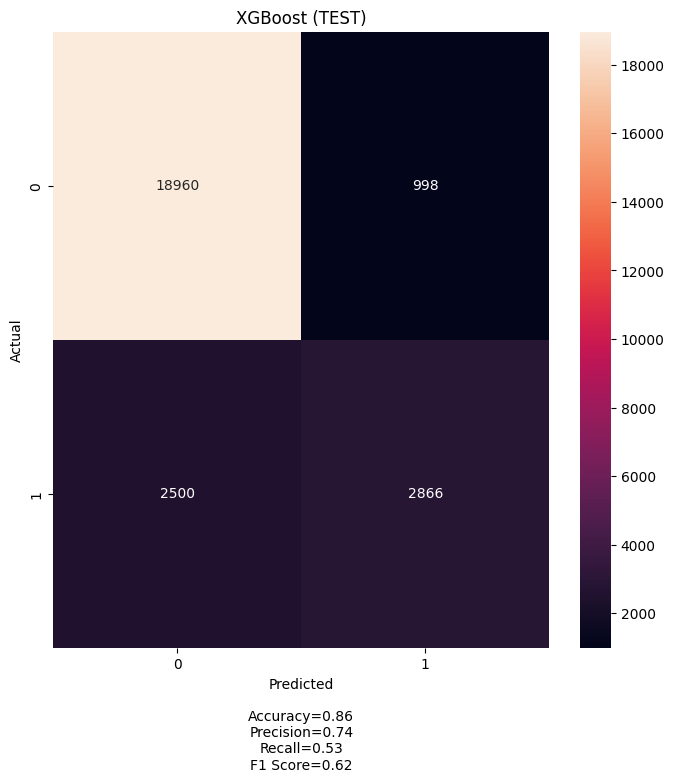

In [16]:
#Predict the data
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

#Visualizing the data
visualize_preds(y_train,y_train_pred, title = 'XGBoost (TRAIN)')
visualize_preds(y_test,y_test_pred, title = 'XGBoost (TEST)')


## Using KNN Imputation cleaned datset

In [17]:
df = pd.read_csv('/content/sc1015-project/data/weatherAUS_knn_impuation.csv')

In [18]:
X = df.drop(['Date', 'RainTomorrow'], axis=1)
y = df['RainTomorrow']
print('Len of X', len(X))
print('Len of y', len(y))

Len of X 145460
Len of y 145460


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [21]:
# Initialize the classifier
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')


# Fit the model
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [22]:
y_pred = model.predict(X_test)
y_pred

array([1, 0, 0, ..., 0, 0, 0])

In [23]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.8523305376048398

Now we will visualize the result

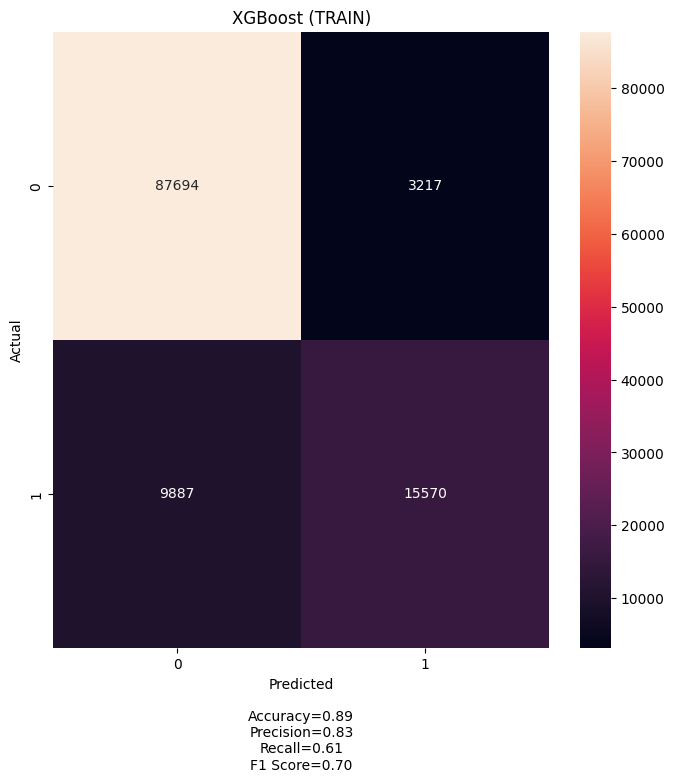

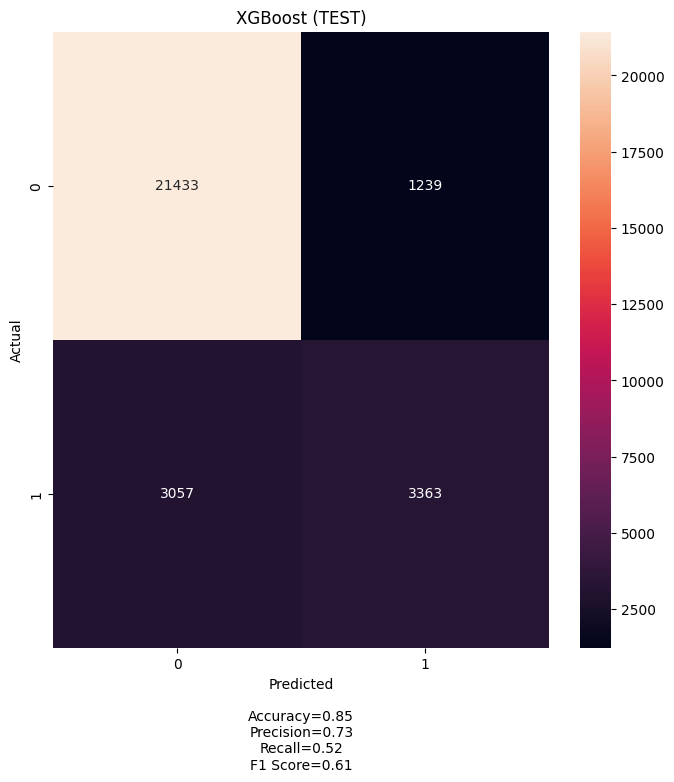

In [24]:
#Predict the data
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

#Visualizing the data
visualize_preds(y_train,y_train_pred, title = 'XGBoost (TRAIN)')
visualize_preds(y_test,y_test_pred, title = 'XGBoost (TEST)')
